# Mapping Mesothelioma

Dr Carl Reynolds
Imperial College London and Royal Brompton Hospital 
@drcjar / drcjar@gmail.com / www.carlreynolds.net

# preparing the data

## 1. mesothelioma mortality data -> regional SMRs

In [146]:
import pandas as pd
import xlrd
from ukpostcodeutils import validation
import shapely.geometry as geom
import geopandas as gpd
from geopandas import GeoDataFrame
import seaborn as sbn

% matplotlib inline

In [147]:
df = pd.read_excel('20171003_Data_for_Carl.xlsx')
df.columns

Index(['HSE_ID', 'SEX', 'YOB', 'YOD', 'AGE', 'POSTCODE'], dtype='object')

In [37]:
len(df)

40798

In [38]:
df.HSE_ID.duplicated().value_counts()

False    40798
Name: HSE_ID, dtype: int64

In [39]:
df.SEX.isnull().value_counts()

False    40798
Name: SEX, dtype: int64

In [40]:
df.YOB.isnull().value_counts()

False    40798
Name: YOB, dtype: int64

In [41]:
df.YOD.isnull().value_counts()

False    40798
Name: YOD, dtype: int64

In [42]:
df.AGE.isnull().value_counts()

False    40798
Name: AGE, dtype: int64

In [43]:
df.SEX.value_counts() # 1 is male 2 is female

1    34507
2     6291
Name: SEX, dtype: int64

In [44]:
df[df.POSTCODE.isnull()].HSE_ID.values

array([  1205,   1800,   7903,  10507,  16506,  23214,  33311,  35611,
        52806,  54008,  55213,  55413,  58014,  62213,  85200,  92099,
        95407, 131398, 138802, 161112, 240014, 248415])

In [45]:
overseas_records = [1205,1800,7903,23214,\
                    33311,35611,54008,55213,\
                    55413,58014,62213,63895,85200,92099,\
                    95407,102795,106395,131398,152415,\
                    161112,206109,240014,248415]

# 53007:SW7 1LW
# 176212:BD20 7RH
# I was advised the above two were overseas but they aren't

In [46]:
record_corrections = {10507:'IV27 4NY', 16506:'S8 7RY',
                     52806:'E11 1PS', 138802: 'NN11 9BJ',
                     13002:'DN2 5SU', 28197:'SE2 0DU', 
                     44101:'CM4 0DD', 52201:'W1U 4NY',
                     53610:'HS5 3TL', 120008:'DY10 3LT',
                     126202:'G81 5QR', 134196:'ST17 0XG',
                     174808:'IP2 0XA', 196708:'OL15 0JF',
                     114105:'NE23 8DT'}

# provided by HSE
# 114105:NE23 8DT 114105:NE23 5DT is my own correction

In [47]:
df = df[~df.HSE_ID.isin(overseas_records)]
df.POSTCODE.update(df.HSE_ID.map(lambda x: record_corrections.get(x)))

In [48]:
df.POSTCODE.isnull().value_counts()

False    40778
Name: POSTCODE, dtype: int64

In [49]:
df['pcd'] = df['POSTCODE']
df['pcd'] = df['pcd'].str.replace(' ','')
df['pcd'] = df['pcd'].str.replace('  ','')
df['pcd'] = df['pcd'].str.upper()

In [50]:
df['pcd'].map(lambda x: validation.is_valid_postcode(x)).value_counts()

True    40778
Name: pcd, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3fb2ddc7b8>,
      dtype=object)

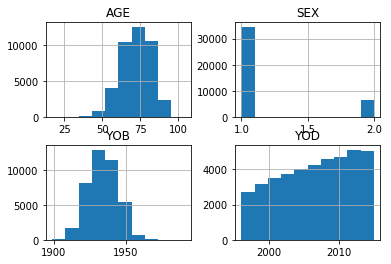

In [51]:
df[['AGE', 'SEX', 'YOB', 'YOD']].hist()

In [52]:
df['COUNT'] = 1 # since 1 row represents one death at present

In [53]:
df['AGEGRP'] = pd.cut(df.AGE, range(15,95,5), 
                    labels=[
                        '15 to 19',
                        '20 to 24',
                        '25 to 29',
                        '30 to 34',
                        '35 to 39',
                        '40 to 44',
                        '45 to 49',
                        '50 to 54',
                        '55 to 59',
                        '60 to 64',
                        '65 to 69',
                        '70 to 74',
                        '75 to 79',
                        '80 to 84',
                        '85 to 90',],
                    right=False) 

## give our datapoints a point

In [54]:
# https://data.gov.uk/dataset/dca79df3-2cf5-40b8-8b27-d0e0d3485077/ons-postcode-directory-latest-centroids
df1 = pd.read_csv('ONS_Postcode_Directory_Latest_Centroids.csv', usecols=[0,1,3])

In [55]:
df1['pcd'] = df1['pcd'].str.replace(' ','')
df1['pcd'] = df1['pcd'].str.replace('  ','')
df1['pcd'] = df1['pcd'].str.upper()

In [56]:
df2 = pd.merge(df, df1, on='pcd')

In [57]:
df2['geometry'] = df2[['X','Y']].apply(geom.Point, axis=1)

In [58]:
crs = {'init': 'epsg:4326'}
gdf = GeoDataFrame(df2, crs=crs)

## assign every point to the right polygon

In [59]:
# http://geoportal.statistics.gov.uk/datasets/wards-december-2016-super-generalised-clipped-boundaries-in-great-britain
# ogr2ogr -f GeoJSON wards.json Wards_December_2016_Super_Generalised_Clipped_Boundaries_in_Great_Britain.kml
wards = gpd.read_file('wards.json')

In [60]:
gdf = gpd.sjoin(gdf, wards[['wd16cd', 'geometry']].copy(), op='within')

## populations for our polygons

In [71]:
# https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/wardlevelmidyearpopulationestimatesexperimental
# note no Scotland and N Ireland (England and Wales only)
df = pd.read_excel('SAPE19DT8-mid-2016-ward-2016-syoa-estimates-unformatted.xls', 2) # males only
columns = df.iloc[3].values
df.drop(df.index[:4], inplace=True)
df.columns = columns
df = df.rename(index=str, columns={"Ward Code 1": "wd16cd"})
df = pd.melt(df.drop(['Ward Name 1', 'Local Authority', 'All Ages'], axis=1), id_vars='wd16cd')
df = df.rename(index=str, columns={"variable": "AGE", 'value':'POP'})
df['SEX'] = 1
men = df

df = pd.read_excel('SAPE19DT8-mid-2016-ward-2016-syoa-estimates-unformatted.xls', 3) # female only
columns = df.iloc[3].values
df.drop(df.index[:4], inplace=True)
df.columns = columns
df = df.rename(index=str, columns={"Ward Code 1": "wd16cd"})
df = pd.melt(df.drop(['Ward Name 1', 'Local Authority', 'All Ages'], axis=1), id_vars='wd16cd')
df = df.rename(index=str, columns={"variable": "AGE", 'value':'POP'})
df['SEX'] = 2
women = df

df = pd.concat([men, women])

df = pd.merge(df, gdf, on=['wd16cd', 'AGE', 'SEX'], how='outer') 

## regional SMRs

In [73]:
nat = df.groupby('AGEGRP').COUNT.sum() / df.groupby('AGEGRP').POP.sum()
nat = nat.reset_index()
nat.columns = ['AGEGRP', 'NATIONAL_RATE']
nat.head()

,AGEGRP,NATIONAL_RATE
0,15 to 19,0.022388
1,20 to 24,0.020619
2,25 to 29,0.012623
3,30 to 34,0.012574
4,35 to 39,0.017442


In [75]:
areas = df.groupby(['wd16cd', 'AGEGRP']).COUNT.sum()
areas = areas.reset_index()
areas.columns = ['wd16cd', 'AGEGRP','OBSERVED']
areas = pd.merge(areas, nat, on='AGEGRP') # adding national age specific rates

areapop = df.groupby(['wd16cd', 'AGEGRP']).POP.sum()
areapop = areapop.reset_index()
areapop.columns = ['wd16cd', 'AGEGRP','POP']
areas = pd.merge(areas, areapop, on=['wd16cd', 'AGEGRP']) # adding local populations

areas = areas[areas.POP != 0] # a few observations lack a population and aren't suitable for SMR calculations
areas['EXPECTED'] = areas['NATIONAL_RATE'] * areas['POP'] # adding expected deaths
areas.head()

,wd16cd,AGEGRP,OBSERVED,NATIONAL_RATE,POP,EXPECTED
0,E05000026,60 to 64,1.0,0.022107,29.0,0.641093
1,E05000028,60 to 64,2.0,0.022107,74.0,1.635893
2,E05000030,60 to 64,2.0,0.022107,107.0,2.365412
3,E05000031,60 to 64,2.0,0.022107,87.0,1.923279
4,E05000032,60 to 64,1.0,0.022107,41.0,0.906373


In [76]:
areas.OBSERVED.sum() # less than what we started with because of loss of Scottish and Irish data

36549.0

In [78]:
areas.POP.sum() # less than national pop because is limited to areas we have deaths in

1425423.0

In [104]:
area_smr = areas.groupby('wd16cd').OBSERVED.sum() / areas.groupby('wd16cd').EXPECTED.sum()
area_smr = area_smr.reset_index()
area_smr.columns = ['wd16cd', 'SMR']
area_smr = pd.merge(wards[['wd16cd', 'geometry']], area_smr, on='wd16cd', how='outer') # geometry
area_smr.SMR = area_smr.SMR.fillna(0) # set SMR to 0 for places with no deaths
area_smr.head()

,wd16cd,geometry,SMR
0,E05000026,"POLYGON ((0.093628519506699 51.53767283618303,...",1.640052
1,E05000027,"POLYGON ((0.161601912696188 51.54332775278261,...",1.445018
2,E05000028,"POLYGON ((0.127155518333555 51.55560636295905,...",1.302787
3,E05000029,"POLYGON ((0.148410021353652 51.58075389095039,...",1.091228
4,E05000030,"POLYGON ((0.190207484104516 51.55268061654229,...",1.127380


In [135]:
area_smr.to_file('meso.json')

## 2. make a choropleth

In [137]:
gdf = gpd.read_file('meso.json')

In [138]:
gdf.head()

,SMR,geometry,wd16cd
0,1.640052,"POLYGON ((0.093628519506699 51.53767283618303,...",E05000026
1,1.445018,"POLYGON ((0.161601912696188 51.54332775278261,...",E05000027
2,1.302787,"POLYGON ((0.127155518333555 51.55560636295905,...",E05000028
3,1.091228,"POLYGON ((0.148410021353652 51.58075389095039,...",E05000029
4,1.127380,"POLYGON ((0.190207484104516 51.55268061654229,...",E05000030


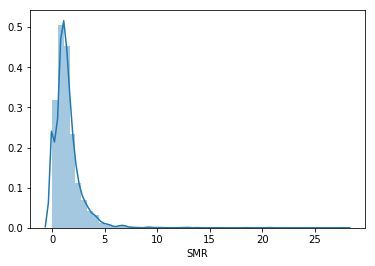

In [139]:
sbn.distplot(gdf['SMR'])

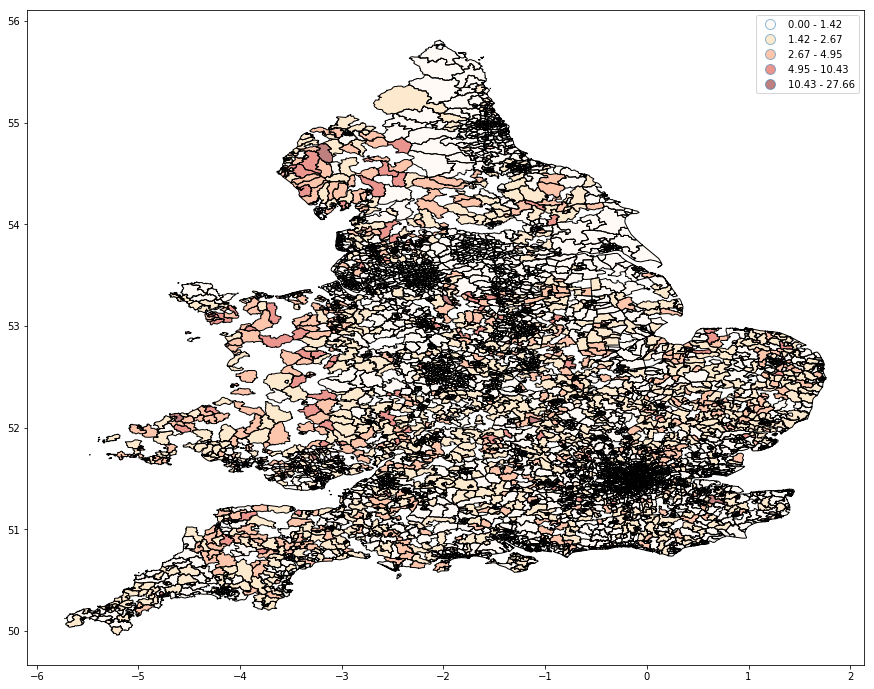

In [145]:
gdf[gdf['SMR'] > 0].plot(figsize=(15, 15), column='SMR', scheme='fisher_jenks', cmap='OrRd', legend=True)